In [1]:
from models import regressionnet
from scripts import tools
from scripts import dataset
from scripts.config import *

%matplotlib inline

tools.etc.set_GPU("2")

In [2]:
net_type = 'convnet1'
net, _, _, _ = regressionnet.create_regression_net(data_shape=(227,227,3),optimizer_type='adadelta',num_joints=14,net_type=net_type, gpu_memory_fraction=None)  
with net.graph.as_default():
    saver = tf.train.Saver()
    saver.restore(net.sess, "./out/convnet1_gpu0_4800.ckpt")
    test_it = dataset.met("./dataset/test.csv", Fliplr=True, Shuffle=False, dataset_root="./dataset/")

INFO:tensorflow:Restoring parameters from ./out/convnet1_gpu0_4800.ckpt


[Mirroring Images & Coordinates]: 100%|██████████| 60/60 [00:00<00:00, 1373.27it/s]


In [3]:
predicted_joints = net.sess.run(
    [net.fc_regression],
    feed_dict={net.x : test_it.img_set, net.keep_prob:1.0})[0]

predicted_joints = predicted_joints.reshape(len(predicted_joints),14,2)
pred_canonical = tools.pose.convert2canonical(predicted_joints)
orig_canonical = tools.pose.convert2canonical(test_it.coor_set)

In [4]:
pcp_value=tools.pose.eval_strict_pcp(orig_canonical,pred_canonical)
average_pcp = tools.pose.average_pcp_left_right_limbs(pcp_value)
for i in range(len(average_pcp[1])):
    print(average_pcp[1][i]+" : "+str(average_pcp[0][i]))

Head : 0.8333333333333334
Torso : 0.975
U Arm : 0.8666666666666667
L Arm : 0.775
U Leg : 0.8125
L Leg : 0.8416666666666667
mean : 0.8506944444444443


In [14]:
orig_img1[:,:,[2,1,0]].shape

(227, 227, 3)

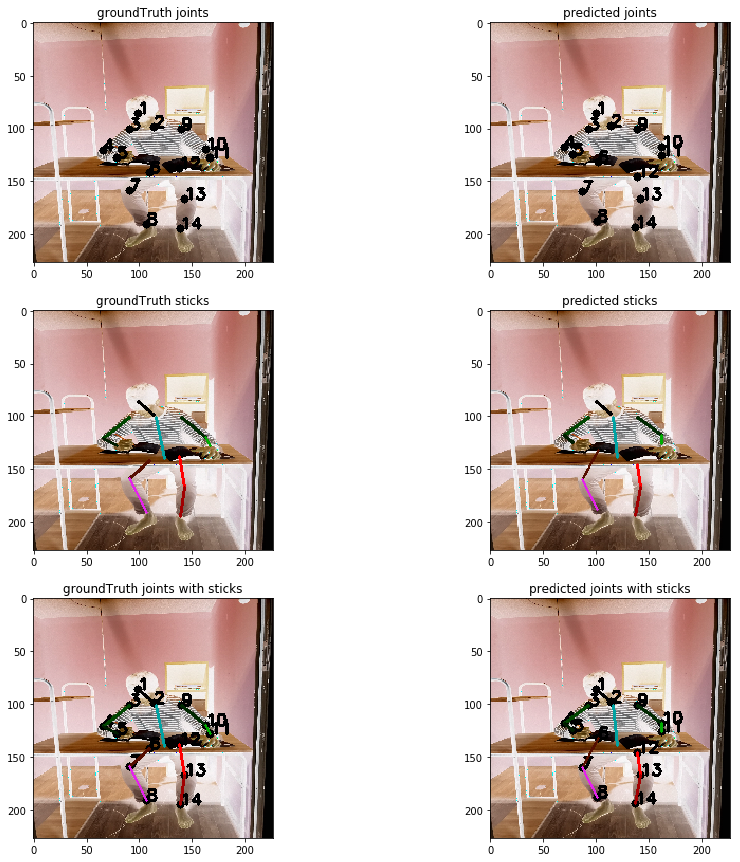

In [36]:
idx=28

orig_img1 = test_it.img_set[idx].copy()
orig_img2 = test_it.img_set[idx].copy()
orig_img3 = test_it.img_set[idx].copy()

pred_img1 = test_it.img_set[idx].copy()
pred_img2 = test_it.img_set[idx].copy()
pred_img3 = test_it.img_set[idx].copy()

tools.etc.markJoints(img=orig_img1, joints=orig_canonical[idx]['joints'])
tools.etc.drawSticks(img=orig_img2, sticks=orig_canonical[idx]['sticks'])

tools.etc.markJoints(img=pred_img1, joints=pred_canonical[idx]['joints'])
tools.etc.drawSticks(img=pred_img2, sticks=pred_canonical[idx]['sticks'])

tools.etc.markJoints(img=orig_img3, joints=orig_canonical[idx]['joints'])  
tools.etc.drawSticks(img=orig_img3, sticks=orig_canonical[idx]['sticks'])  

tools.etc.markJoints(img=pred_img3, joints=pred_canonical[idx]['joints'])
tools.etc.drawSticks(img=pred_img3, sticks=pred_canonical[idx]['sticks'])

fig, ((p11,p12),(p21,p22),(p31,p32),) = plt.subplots(3,2)
fig.set_size_inches(15, 15)

p11.set_title("groundTruth joints")
p11.imshow(orig_img1)
p12.set_title("predicted joints")
p12.imshow(pred_img1)

p21.set_title("groundTruth sticks")
p21.imshow(orig_img2)
p22.set_title("predicted sticks")
p22.imshow(pred_img2)

p31.set_title("groundTruth joints with sticks")
p31.imshow(orig_img3)
p32.set_title("predicted joints with sticks")
p32.imshow(pred_img3)